https://ithelp.ithome.com.tw/articles/10233234  
Day 27 : 股市 K 線 LINE 聊天機器人實作 (功能實作)  
https://ithelp.ithome.com.tw/articles/10241574  

建立bbands教材，詳細說明策略的想法，並實際計算績效
1. 畫出bbands，並且沒有出現空缺
2. 完成不同策略的判斷、並畫出買賣點
3. 分析此策略的績效並改進

In [145]:
import os
path = "C:/Users/Landis/Desktop/pystocks"
lists = [i for i in os.listdir(path) if '.csv' in i]
print(lists)

['0050.csv', '0056.csv', '2317.csv', '2330.csv', '2610.csv']


<bound method NDFrame.head of               Open    High     Low   Close  Volume
Date                                              
2022-07-25  116.30  116.95  116.00  116.70   10845
2022-07-26  116.60  116.60  115.30  115.65   13077
2022-07-27  115.50  116.70  115.15  116.70    7896
2022-07-28  117.85  117.95  116.90  116.90    8290
2022-07-29  118.15  118.50  117.65  118.00    7986
2022-08-01  118.10  118.10  117.20  117.65    9482>


C:\Users\Landis\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


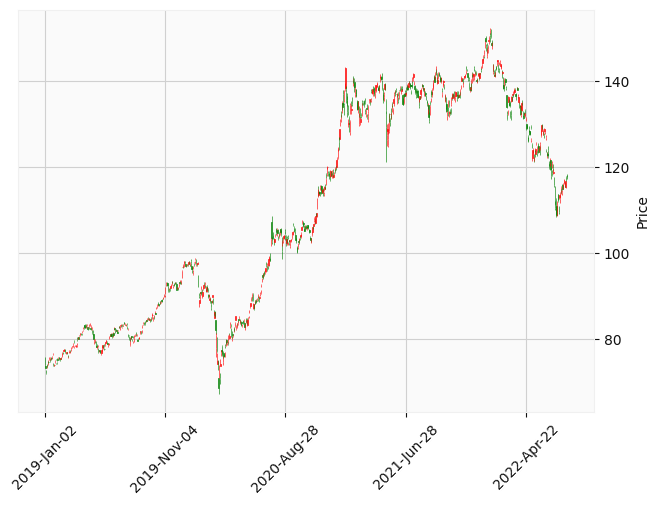

In [150]:
import pandas as pd
import mplfinance as mpf
# 讀取股票檔案，最新100筆資料
SData = pd.read_csv('0050.csv',index_col='Date')
# 更改時間格式
SData.index = pd.DatetimeIndex(SData.index)
print(SData.iloc[-6:,:].head)
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
mpf.plot(SData, type='candle', style =s)

In [151]:
print(len(SData))

870


## 建立布林通道函式
1. 布林通道的定義為，K為標準差數量，N為過去幾筆資料:

    中軌 = N時間段的簡單移動平均線

    上軌 = 中軌 + K * N時間段的標準差

    下軌 =  中軌 - K * N時間段的標準差


2. 圖中藍線是上軌、橘線是中軌、綠色是下軌，常用的計算方式為N = 20、K = 2，也就是說中軌的每個點都是前20筆價格的平均

 

3. 標準差的計算方式為N時間段的每筆數值減去平均值的平方和再除以N後開根號，計算出來的標準差代回到布林通道的公式中就可以得到上下軌



In [8]:
def BBands(data, period=20, std_num=2):
    
    res = data.copy(deep=True)                                   # 取得data資料
    res['b_mid'] = data['Close'].rolling(period).mean()  # 計算中線(20日均線)
    std = data['Close'].rolling(period).std(ddof=0)              # 計算用於上下軌的標準差
    res['b_up'] = res['b_mid'] + std * std_num   # 計算上軌
    res['b_low'] = res['b_mid'] - std * std_num   # 計算下軌

    return res

In [70]:
SData = pd.read_csv('2330.csv',index_col='Date')
SData.index = pd.DatetimeIndex(SData.index)   # 更改時間格式
#print(SData)

bbands_data = BBands(SData)   # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 新增布林通道後資訊
print(bbands_data.columns)
print(bbands_data)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'b_mid', 'b_up', 'b_low'], dtype='object')
             Open   High    Low  Close  Volume    b_mid        b_up  \
Date                                                                  
2021-01-04  530.0  540.0  528.0  536.0   39490      NaN         NaN   
2021-01-05  536.0  542.0  535.0  542.0   34839      NaN         NaN   
2021-01-06  555.0  555.0  541.0  549.0   55614      NaN         NaN   
2021-01-07  554.0  570.0  553.0  565.0   53393      NaN         NaN   
2021-01-08  580.0  580.0  571.0  580.0   62957      NaN         NaN   
...           ...    ...    ...    ...     ...      ...         ...   
2022-07-26  499.5  499.5  491.0  495.0   19524  474.800  518.152509   
2022-07-27  494.0  502.0  491.0  502.0   17077  475.350  519.776456   
2022-07-28  509.0  509.0  499.0  501.0   33767  476.600  522.414408   
2022-07-29  508.0  510.0  504.0  509.0   28855  479.375  525.973149   
2022-08-01  506.0  508.0  500.0  504.0   24080  482.575 

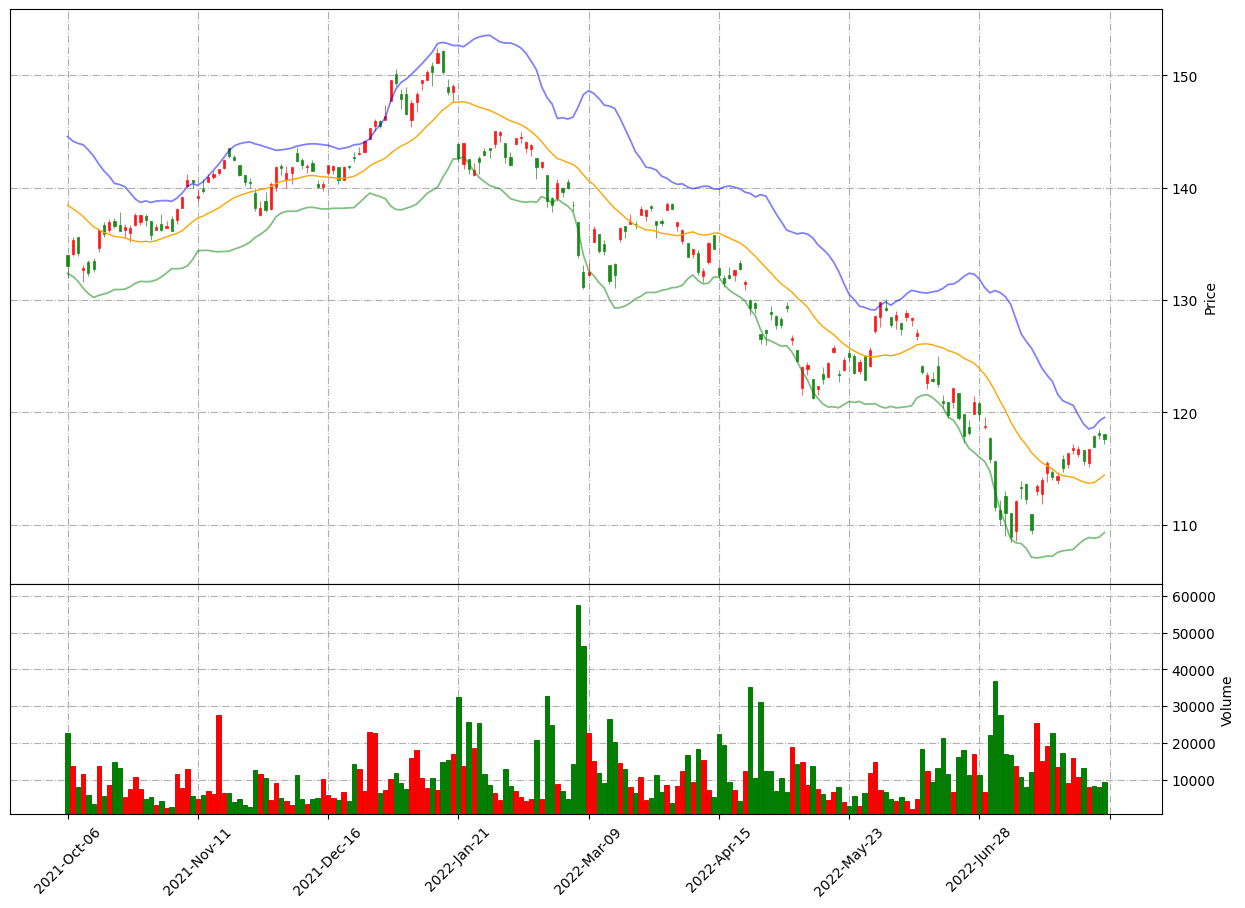

In [152]:
day_num = 200                            # 設定顯示股價資訊的天數
bbands_data = BBands(SData)              # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 繪製布林通道線圖
addplots = [
            mpf.make_addplot(bbands_data['b_mid'][-day_num:], panel=0, color='orange', alpha=1
                             , width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['b_up'][-day_num:], color = 'blue', alpha=0.5),
            mpf.make_addplot(bbands_data['b_low'][-day_num:], color = 'green', alpha=0.5)
           ]

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.iloc[-day_num:,:],
         #mav = [10, 20, 60],
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [12]:
bbands_data.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01'],
              dtype='datetime64[ns]', name='Date', length=383, freq=None)

In [153]:
bbands_data.loc['2021-01-04', 'Low']

122.0

In [154]:
SData.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

## 建立回測規則函式

In [155]:
import numpy as np
buy = [np.nan]
s = SData.copy(deep=True).iloc[-3:,:]
buy.append(np.nan)
buy.append(bbands_data.loc['2021-01-04', 'Low'])
print(buy)
s['sell_point'] = buy
print(s)

[nan, nan, 122.0]
              Open    High     Low   Close  Volume  sell_point
Date                                                          
2022-07-28  117.85  117.95  116.90  116.90    8290         NaN
2022-07-29  118.15  118.50  117.65  118.00    7986         NaN
2022-08-01  118.10  118.10  117.20  117.65    9482       122.0


In [229]:
import numpy as np
def bbands_rule(_ticker, bb_period=20, bb_stdnum=2):
    
    temp = 1.5  # 設定買賣點的距離
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'b_mid', 'b_up', 'b_low'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    buy_1 = [np.nan]
    sell_1 = [np.nan]

    # 取得 index 值(日期)，方便計算使用
    t = res.index


#     # 判斷布林通道的斜率
#     for i in range(1, len(res)):
#         slope = (bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i-1], 'b_up']-1) * 100
#         slope.append(s)
#         if (s)>1:
#             test.append(bbands_data.loc[t[i], 'b_up'] + temp)
#             print("斜率:", (bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i-1], 'b_up']-1) * 100)
#         else:
#             test.append(np.nan)

#             if (res.loc[t[i], 'Open'] < res.loc[t[i], 'Close']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
#                 buy.append(res.loc[t[i], 'Low'] - temp)
#             else:    

    for i in range(1, len(res)):
        slope = (bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i-1], 'b_up']-1) * 100    # 計算布林通道上軌斜率
        # 計算是否符合買進條件
        if ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) > 15:  # 通道寬度大於15%
            if res.loc[t[i], 'Low'] < res.loc[t[i], 'b_low']:                              # K棒碰觸到下軌
                buy_1.append(res.loc[t[i], 'Low'] - temp)
            else:
                buy_1.append(np.nan)
        else:
                buy_1.append(np.nan)

        # 計算是否符合做空首要條件
        if ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) > 15: # 通道寬度大於15%
            if res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:                            # 收盤價突破上軌
                sell_1.append(res.loc[t[i], 'High'] + temp)
            else:
                sell_1.append(np.nan)    
        else:
            sell_1.append(np.nan)
    res['buy_point'] = buy_1
    res['sell_point'] = sell_1
    return res

In [226]:
bbands_data = bbands_rule(SData)

C:\Users\Landis\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


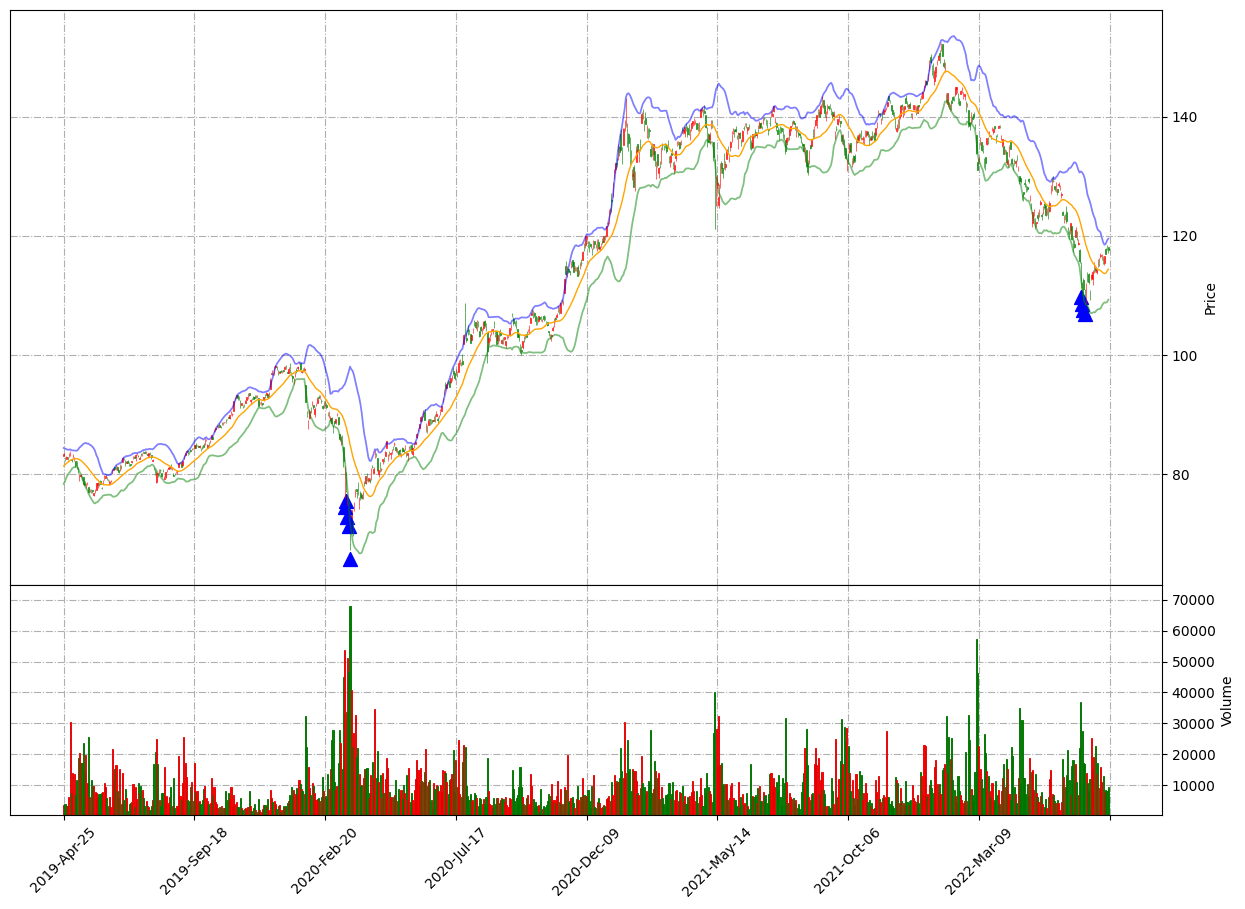

In [283]:
day_num = 800                                  # 設定顯示股價資訊的天數
bbands_data = bbands_rule(SData)              # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 繪製布林通道線圖
addplots = [
            mpf.make_addplot(bbands_data['b_mid'][-day_num:], panel=0, color='orange', alpha=1
                             , width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['b_up'][-day_num:], color = 'blue', alpha=0.5),
            mpf.make_addplot(bbands_data['b_low'][-day_num:], color = 'green', alpha=0.5),
            mpf.make_addplot(bbands_data['buy_point'][-day_num:], color = 'blue', alpha=1, type='scatter', marker='^', markersize=100),
            #mpf.make_addplot(bbands_data['sell_point'][-day_num:], color = 'green', alpha=0.5, type='scatter', marker='v', markersize=100),
            #mpf.make_addplot(bbands_data['test'][-day_num:], color = 'red', alpha=0.5, type='scatter', marker='v', markersize=100)
           ]

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.iloc[-day_num:,:],
         #mav = [10, 20, 60],
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [2]:
def bbands_ema_rule(_ticker, buy_point_name='buy_point', 
        bb_period=20, bb_stdnum=2, ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
        if not {'EMA_' + str(ma_period)}.issubset(res.columns):
            res = EMA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 判斷前幾日始否跌破下軌了
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        # 計算是否符合做多首要條件
        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False

        # 計算是否符合做空首要條件
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        # 計算做多點
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] > res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_middle'] > res.loc[t[i - 1], 'bbands_middle'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = 1
        
        # 計算做空點
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] < res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = -1

    return res